In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import datetime
import time

In [ ]:
"""
read data (processed_data)
"""
idxname = pd.read_csv("data/index.csv", sep='\t')
stkname = pd.read_csv("data/stocks.csv", sep='\t')

indicators = []
stocks = []
for filename in idxname.filename:
    indicators.append(pd.read_csv("processed_data/index/"+filename))
for filename in stkname.symbol:
    stocks.append(pd.read_csv("processed_data/stocks/"+filename))

#print(indicators[0])
#print(stocks[0])

"""
Data preparation
"""
max0day = int(stocks[0].loc[stocks[0].iloc[:,1]==0].Date.max())

#stocks[0].iloc[max0day:,1:5].plot()
#plt.show()
data = stocks[0].iloc[max0day+1:].Close

train = data.iloc[:-730]
test = data.iloc[-730:]

In [2]:
"""
read data (original)
"""
idxname = pd.read_csv("data/index.csv", sep='\t')
stkname = pd.read_csv("data/stocks.csv", sep='\t')

indicators = []
stocks = []
for filename in idxname.filename:
    indicators.append(pd.read_csv("data/index/"+filename).fillna(0))
for filename in stkname.symbol:
    stocks.append(pd.read_csv("data/stocks/"+filename).fillna(0))

#print(indicators[0])
#print(stocks[0])

"""
Data preparation
"""
data = stocks[0].Close

train = data.iloc[:-730]
test = data.iloc[-730:]

In [3]:
train = train.values
test = test.values

In [4]:
train_x = np.array([train[i:i+365] for i in range(len(train)-365)])[:,:, np.newaxis]
train_y = np.array([train[i+365] for i in range(len(train)-365)])[:, np.newaxis]

test_x = np.array([test[i:i+365] for i in range(len(test)-365)])[:,:, np.newaxis]
test_y = np.array([test[i+365] for i in range(len(test)-365)])[:, np.newaxis]

# print(train_x)
# print(len(train_x))
# print(train_y)
# print(len(train_y))
print(train_x.shape)
print(train_y.shape)

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
data_gen = TimeseriesGenerator(train, train, length=365, batch_size=128)

#x, y = data_gen[0]
#print(x)
#print(len(x))
#print(y)
#print(len(y))

(8648, 365, 1)
(8648, 1)


In [5]:
scalers_train = []
for i in range(len(train_x)):
    scaler = MinMaxScaler()
    train_x[i] = scaler.fit_transform(train_x[i])
    train_y[i,0] = scaler.transform(train_y)[i,0]
    scalers_train.append(scaler)

scalers_test = []
for i in range(len(test_x)):
    scaler = MinMaxScaler()
    test_x[i] = scaler.fit_transform(test_x[i])
    test_y[i,0] = scaler.transform(test_y)[i,0]
    scalers_test.append(scaler)

In [6]:
"""
LSTM
"""
model = tf.keras.Sequential()
#model.add(layers.BatchNormalization())
# (i)
model.add(layers.LSTM(128, return_sequences=True, dropout=.5,
                     input_shape=(None, 1)))
#model.add(layers.BatchNormalization())
model.add(layers.LSTM(64))
#model.add(layers.Flatten())
model.add(layers.Dense(1))
#model.add(layers.CuDNNLSTM(128))
# (ii)
#model.add(layers.Bidirectional(layers.LSTM(128), return_sequences=True))
#model.add(layers.Bidirectional(layers.LSTM(64)))

adam = tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mse'])
#model.compile(loss='mse', optimizer=adam, metrics=['mse'])

model.build()
print(model.summary())

model.fit(train_x, train_y,
          shuffle = True,
          epochs=200)

# model.fit_generator(data_gen, 
#                     epochs=200, 
#                     shuffle=True)

W0808 16:21:05.564444 139780778710848 deprecation.py:506] From /home/c405/venv/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0808 16:21:05.968113 139780778710848 deprecation.py:323] From /home/c405/venv/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 128)         66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
8648/8648 [==============================] - 139s 16ms/sample - loss: 0.0647 - mean_squared_error: 0.0647
Epoch 2/200
8648/8648 [==============================] - 138s 16ms/sample - loss: 0.0368 - mean_squared_error: 0.0368
Epoch 3/200
8648/8648 [==============================] - 138s 16ms/sample - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 4/200
8648/8648

8648/8648 [==============================] - 138s 16ms/sample - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 64/200
8648/8648 [==============================] - 138s 16ms/sample - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 65/200
8648/8648 [==============================] - 138s 16ms/sample - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 66/200
8648/8648 [==============================] - 138s 16ms/sample - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 67/200
8648/8648 [==============================] - 138s 16ms/sample - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 68/200
8648/8648 [==============================] - 138s 16ms/sample - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 69/200
8648/8648 [==============================] - 138s 16ms/sample - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 70/200
8648/8648 [==============================] - 138s 16ms/sample - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 71/200
8648/8648 [==============================] - 138

8648/8648 [==============================] - 138s 16ms/sample - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 132/200
8648/8648 [==============================] - 138s 16ms/sample - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 133/200
8648/8648 [==============================] - 138s 16ms/sample - loss: 0.0090 - mean_squared_error: 0.0090
Epoch 134/200
8648/8648 [==============================] - 138s 16ms/sample - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 135/200
8648/8648 [==============================] - 138s 16ms/sample - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 136/200
8648/8648 [==============================] - 138s 16ms/sample - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 137/200
8648/8648 [==============================] - 138s 16ms/sample - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 138/200
8648/8648 [==============================] - 138s 16ms/sample - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 139/200
8648/8648 [=============================

8648/8648 [==============================] - 138s 16ms/sample - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 200/200
8648/8648 [==============================] - 138s 16ms/sample - loss: 0.0083 - mean_squared_error: 0.0083


In [16]:
model.save_weights('LSTM_weights.h5')

In [8]:
score = model.evaluate(test_x, test_y)
print(score)
pred_y = model.predict(test_x)
from sklearn.metrics import mean_squared_error
from math import sqrt
print(sqrt(mean_squared_error(test_y, pred_y)))

365/365 [==============================] - 2s 5ms/sample - loss: 0.1442 - mean_squared_error: 0.1442
[0.14418677520262052, 0.14418676]
0.37971933587373197


In [14]:
test_y_or = []
pred_y_or = []
for i in range(len(scalers_test)):
    test_y_or.append(scalers_test[i].inverse_transform(test_y)[i,0])
    pred_y_or.append(scalers_test[i].inverse_transform(pred_y)[i,0])
print(sqrt(mean_squared_error(test_y_or, pred_y_or)))

30.67391749863925


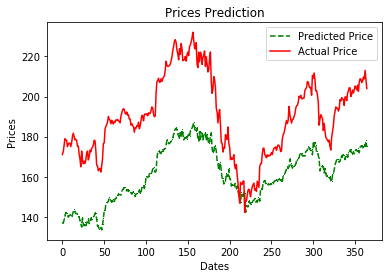

In [15]:
#plt.figure(figsize=(12,7))
#%matplotlib qt

#plt.plot(data, 'green', color='blue', label='Training Data')
plt.plot(pred_y_or, 
         color='green', 
         marker=',', #'o', 
         linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_y_or, color='red', label='Actual Price')
plt.title('Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
#plt.xticks(np.arange(0,1857, 300), stocks[0]['Date'][0:1857:300])
#plt.xticks(np.arange(max0day+1,len(data), 300), stocks[0]['Date'][max0day+1:len(data):300])
plt.legend()
plt.show()

There are some gap.